In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb

df = pd.read_csv("/kaggle/input/small-nice-data-dota2/small_nice_data.csv",
                 index_col=0)

df.head()

,time,radiant_roshankill,radiant_Δroshankill,dire_roshankill,dire_Δroshankill,good_tower1,good_tower2,good_tower3,good_melee,good_range,...,radiant_buyback,dire_buyback,radiant_Δrunes,dire_Δrunes,radiant_runes,dire_runes,radiant_aegis,dire_aegis,radiantΔaegis,direΔaegis
0,0,0,0,0,0,3,3,3,3,3,...,0,0,1,1,1,1,0,0,0,0
1,60,0,0,0,0,3,3,3,3,3,...,0,0,1,1,2,2,0,0,0,0
2,120,0,0,0,0,3,3,3,3,3,...,0,0,0,0,2,2,0,0,0,0
3,180,0,0,0,0,3,3,3,3,3,...,0,0,0,0,2,2,0,0,0,0
4,240,0,0,0,0,3,3,3,3,3,...,0,0,0,0,2,2,0,0,0,0


In [2]:
df['time'].describe()

count    164300.000000
mean       1072.197079
std         734.369752
min           0.000000
25%         480.000000
50%        1020.000000
75%        1560.000000
max        5820.000000
Name: time, dtype: float64

In [3]:
y = df['time']
X = df.drop(columns='time')

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [6]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OneHotEncoder(sparse_output=False))
           ])  

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor
     

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['radiant_roshankill', 'radiant_Δroshankill', 'dire_roshankill',
       'dire_Δroshankill', 'good_tower1', 'good_tower2', 'good_tower3',
       'good_melee', 'good_range', 'good_fort', 'bad_tower1', 'bad_tower2',
       'bad_tower3', 'bad_melee', 'bad_range', 'bad_fort', 'id', 'y...
       'radiant_kills', 'dire_kills', 'radiant_Δbuyback', 'dire_Δbuyback',
       'radiant_buyback', 'dire_buyback', 'radiant_Δrunes', 'dire_Δrunes',
       'radiant_runes', 'dire_runes', 'radiant_aegis', 'dire_aegis',
       'radiantΔaegis', 'direΔaegis'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 Index([], dtype='object'))])

In [7]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [8]:
model = lgb.LGBMRegressor(objective='mse',
                          n_estimators = 10)

In [9]:
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_names = ['test', 'train'],
          eval_metric='mae')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8357
[LightGBM] [Info] Number of data points in the train set: 131440, number of used features: 82
[LightGBM] [Info] Start training from score 1072.303256


LGBMRegressor(n_estimators=10, objective='mse')

In [10]:
from sklearn import metrics

def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [11]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,213.30,211.93
RMSE,265.86,263.93
R2,0.87,0.87


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

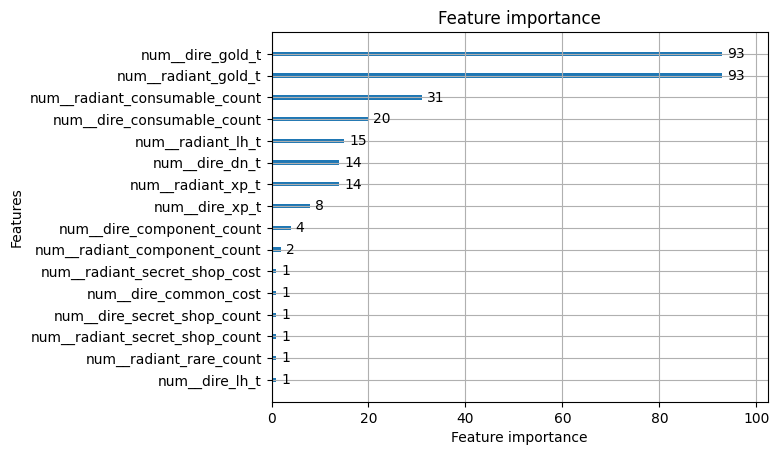

In [12]:
lgb.plot_importance(model, max_num_features=20)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

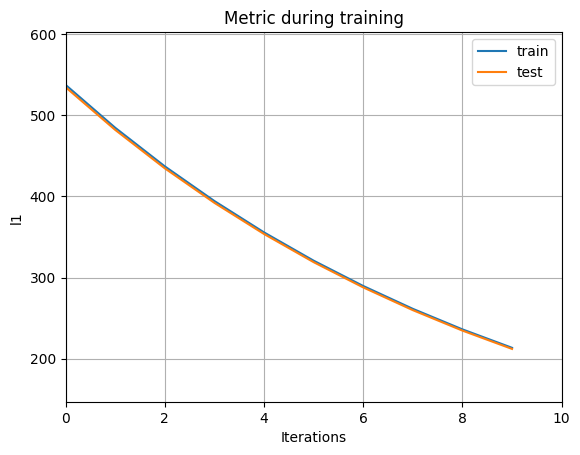

In [13]:
lgb.plot_metric(model,
                metric='l1')

In [14]:
model = Pipeline(
    [("prep", preprocessor),
     ("model", model)
     ]
)

model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['radiant_roshankill', 'radiant_Δroshankill', 'dire_roshankill',
       'dire_Δroshankill', 'good_tower1', 'good_tower2', 'good_tower3',
       'good_melee', 'good_range', 'good_fort', 'bad_tower1', 'bad_tower2',
       'bad_tower3', 'bad_melee', 'bad_r...
       'radiant_buyback', 'dire_buyback', 'radiant_Δrunes', 'dire_Δrunes',
       'radiant_runes', 'dire_runes', 'radiant_aegis', 'dire_aegis',
       'radiantΔaegis', 'direΔaegis'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  Index([], dtype='object'))])),
                ('model', LGBMRegressor(n_estimators=10, objective='mse'))])

In [15]:
import joblib
joblib.dump(model, 'my_model.pkl')

['my_model.pkl']

In [16]:
load_model = joblib.load('my_model.pkl')
load_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['radiant_roshankill', 'radiant_Δroshankill', 'dire_roshankill',
       'dire_Δroshankill', 'good_tower1', 'good_tower2', 'good_tower3',
       'good_melee', 'good_range', 'good_fort', 'bad_tower1', 'bad_tower2',
       'bad_tower3', 'bad_melee', 'bad_r...
       'radiant_buyback', 'dire_buyback', 'radiant_Δrunes', 'dire_Δrunes',
       'radiant_runes', 'dire_runes', 'radiant_aegis', 'dire_aegis',
       'radiantΔaegis', 'direΔaegis'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  Index([], dtype='object'))])),
                ('model', LGBMRegressor(n_estimators=10, objective='mse'))])

In [17]:
data = df.sample(1)
data

,time,radiant_roshankill,radiant_Δroshankill,dire_roshankill,dire_Δroshankill,good_tower1,good_tower2,good_tower3,good_melee,good_range,...,radiant_buyback,dire_buyback,radiant_Δrunes,dire_Δrunes,radiant_runes,dire_runes,radiant_aegis,dire_aegis,radiantΔaegis,direΔaegis
26359,360,0,0,0,0,3,3,3,3,3,...,0,0,2,0,5,3,0,0,0,0
